In [111]:
from gurobipy import *
import random
from array import *
import json
import distance_buffer as db
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors
import numpy as np

# Flow

1. Read in potential tower locs with interference below threshold from kriging results 
2. Read in the population / location data from the input file
3. perform the optimization
4. Output the chosen node (i.e., the chosen tower location pt.)

### 1. read in potl tower locs

In [21]:
#JSON FORMAT:
#{"lats":list(lat_mesh_flat),"long":list(long_mesh_flat),"zdata":z.data.tolist(),"ss":ss.data.tolist()}


with open("est_pts.json", "r") as read_file:
     data = json.load(read_file)

In [87]:
tmp = data[0]
twr_lats = tmp[0]
twr_longs = tmp[1]

twr_coords = list(zip(twr_lats, twr_longs))

In [42]:
lat_mesh, long_mesh = np.meshgrid(twr_lats, twr_longs)

In [90]:
lat_mesh_flat = list(lat_mesh.flatten())
long_mesh_flat = list(long_mesh.flatten())

In [95]:
np.shape(lat_mesh)

(200, 200)

### 2. read in pop file

In [5]:
dmd_locs_lat = [33.149337,33.150123,33.150447,33.150053]
dmd_locs_long = [-116.658376,-116.658270,-116.659746,-116.660193]

In [96]:
tmp_locs_lat = [33.149,33.150,33.150,33.1]
tmp_locs_long = [-116.658,-116.65,-116.65,-116.660]

### 3. find the n (covering set) for the data points

In [26]:
def generate_set_N(i_site, j_site, S, tol):
        # TODO: need to use rtree or something to find the N set(might have done?)
    # N[i] is the covering set of i (all j that can cover i)
    i_site_n = len(i_site)
    j_site_n = len(j_site)
    maxdist = S+(S*tol)
    degtokm = 111.
    N = {}
    for i in range(i_site_n):
        N[i] = []
        for j in range(j_site_n):
            if distance(i_site[i], j_site[j])*degtokm <= maxdist:
                N[i].append(j)

    return N

In [27]:
def distance(a,b):
    # can alter to be geographic distance, but this should be ok for short distances that we're dealing with
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return math.sqrt(dx*dx + dy*dy)


In [101]:
# we want regions covered by each tower, so simply switch the args...
dmd_coords = list(zip(dmd_locs_lat, dmd_locs_long))
tmp_coords = list(zip(tmp_locs_lat,tmp_locs_long))
covering_set = generate_set_N(dmd_coords, tower_coords, 10, 0)



In [104]:
dmd_coords

[(33.149337, -116.658376),
 (33.150123, -116.65827),
 (33.150447, -116.659746),
 (33.150053, -116.660193)]

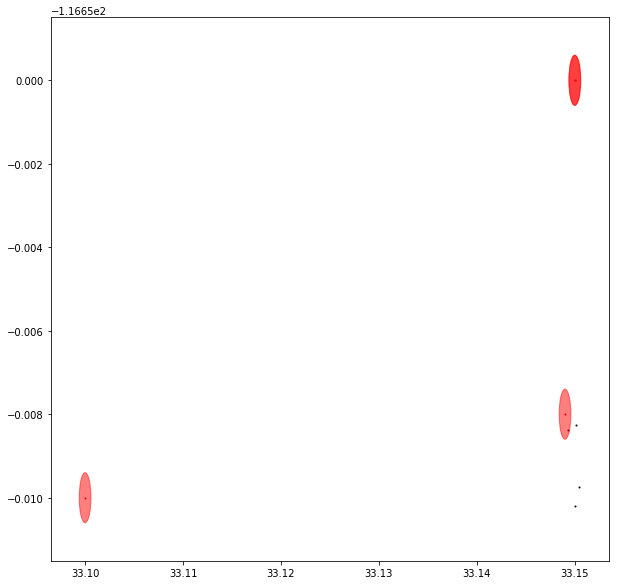

In [110]:

fig0 = plt.figure(figsize=(10,10))  # create a figure object
ax0 = fig0.add_subplot(1, 1, 1)  # create an axes object in the figure
ax0.scatter(tmp_locs_lat,tmp_locs_long, s=1, color="red")
ax0.scatter(dmd_locs_lat,dmd_locs_long, s=1, color="black")

db.plot_radii(ax0, np.array(zip(tmp_locs_lat,tmp_locs_long)), (.0006), alpha=0.5, color='red')



In [29]:
covering_set

{0: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 1: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,

### 3. perform opt

In [2]:
matrix = [[0]*3 for i in range(3)]

for i in range(3):
    for j in range(3):
        matrix[i][j] = [random.uniform(33.15564023, 33.21248565),random.uniform(-116.7374455, -116.6731731)]

# Problem Data
# Population in each region
pop = [523, 690, 420, 1010, 1200, 850, 400, 1008, 950]
# demand points covered by each tower
sites = [[0,1,5], [0,7,8], [2,3,4,6], [2,5,6],
         [0,2,6,7,8], [3,4,8]]
# Cost to build tower (in millions of dollars)
cost = [4.2, 6.1, 5.2, 5.5, 4.8, 9.2]
# Allocated budget (in millions of dollars)
budget = 20

numR = len(pop) # Number of regions
numT = len(sites) # Number of sites for towers

m = Model()

t = {} # Binary variables for each tower
r = {} # Binary variable for each region

for i in range(numT):
  t[i] = m.addVar(vtype=GRB.BINARY, name="t%d" % i)

for j in range(numR):
  r[j] = m.addVar(vtype=GRB.BINARY, name="r%d" % j)

m.update()

for j in range(numR):
  m.addConstr(quicksum(t[i] for i in range(numT) if j in sites[i]) >= r[j])

m.addConstr(quicksum( cost[i]*t[i] for i in range(numT) ) <= budget)

m.setObjective(quicksum( pop[j]*r[j] for j in range(numR) ), GRB.MAXIMIZE)

m.optimize()

Academic license - for non-commercial use only
Optimize a model with 10 rows, 15 columns and 36 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [4e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 4 rows and 5 columns
Presolve time: 0.01s
Presolved: 6 rows, 10 columns, 21 nonzeros
Variable types: 0 continuous, 10 integer (10 binary)

Root relaxation: objective 7.051000e+03, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7051.0000000 7051.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 7051 -0 

Optimal solution found (tolerance 1.00e-04)
Best ob

### 4. output chosen tower loc